In [4]:
from utils import save_submission, load_data
import numpy as np
import copy
import matplotlib.pylab as plt
%matplotlib inline
CLASSES = 10 # note: could have inferred this automatically from the labels

In [5]:
def softmax(Z):
    """
    Convert a set of scores from a linear model into a softmax posterior
    Input:
    Z: N x C array of scores
        Z[n][:] is the set of scores for C classes for the n-th example
    Output:
    S: N x C array
        S[n][:] is the softmax distribution over C classes for the n-th example
    """
    # for 1d inputs
    if Z.ndim == 1:
        Z = Z - np.max(Z)
        return np.exp(Z) / np.sum(np.exp(Z))

    # for matrix inputs
    Z = Z - np.max(Z, axis=1, keepdims=True)
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:x 
    X : N x d array (no unit terms)
    model : dictionary containing 'weight' and 'bias'
    Output:
    yhat : N x C array
        yhat[n][:] contains the softmax posterior distribution over C classes for X[n][:]
    """
    return softmax(np.dot(X, model['weight']) + model['bias'])

def test(X, Y, model):
    """
    Compute hard label assignments based on model predictions, and return the accuracy vector
    Input:
    X : N x d array of data (no constant term)
    Y : N x C array with 1-hot encoding of true labels
    model: dictionary 
    Output:
    acc : N array of errors, acc[n] is 1 if correct and 0 otherwise
    """
    return predict(X, model).argmax(-1) == Y.argmax(-1)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    return 1 - test(X, Y, model).mean()

def calc_loss(X, Y, model):
    """
    Evaluate the loss (without regularization penalty), i.e., normalized negative log likelihood
    """
    Z = predict(X, model)
    return -(Y * np.log(Z)).sum() / len(Y)

In [70]:
def calcGrad(X, Y, model):
    """
    Calculate the gradient of the loss w.r.t. model parameters
    Output:
    grad_W : same dimension as model['weight']; gradient w.r.t. the weights
    grad_b : same dimension as model['bias']; gradient w.r.t. the bias terms
    """
    
    grad_W = np.zeros_like(model['weight'], dtype=np.float64)
    grad_b = np.zeros_like(model['bias'], dtype=np.float64)
    
    Z = predict(X, model)
    N = X.shape[0]
    
    # slow and imperative for now
    for x, y, z in zip(X, Y, Z):
        w_grad = (y - z).reshape((1,10))
        x = x.reshape((x.shape[0],1))
        grad_W -= np.matmul(x, w_grad)
        grad_b += z - y
    
    return grad_W / N, grad_b / N

def modelUpdate(X, Y, model, lambda_, eta):
    """
    Update the model
    Input:
    X, Y : the inputs and 1-hot encoded labels
    model : the currrent model
    lambda : regularization coefficient for L2 penalty
    eta : learning rate
    Output:
    updated model
    """
    grad_W, grad_b = calcGrad(X, Y, model)
    
    model['weight'] -= eta * (grad_W + lambda_ * model['weight'])
    model['bias'] -= eta * grad_b
    
    return model

def runTrainVal(X, Y, model, Xval, Yval, trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    """
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]
        bY = Y[shuffled_idx[batch_idx],:]
        if (iteration % trainopt['display_iter']) == 0:
            print('{:8} batch loss: {:.3f}'.format(iteration, calc_loss(bX, bY, model)))
        model = modelUpdate(bX, bY, model, trainopt['lambda'], eta)
        start_idx = stop_idx % N
        
    # compute train and val error; multiply by 100 for readability (make it percentage points)
    trainError = 100 * error_rate(X, Y, model)
    valError = 100 * error_rate(Xval, Yval, model)
    
    return model, valError, trainError

In [71]:
data_fn = "nmnist.h5"

print("Load small train.")
Xsmall, Ysmall = load_data(data_fn, "small_train")
print(Xsmall.shape)
print(Ysmall.shape)

print("Load large train.")
Xlarge, Ylarge = load_data(data_fn, "large_train")
print(Xlarge.shape)
print(Ylarge.shape)

print("Load val.")
Xval, Yval = load_data(data_fn, "val")
print(Xval.shape)
print(Yval.shape)

Load small train.
(400, 576)
(400, 10)
Load large train.
(7000, 576)
(7000, 10)
Load val.
(2000, 576)
(2000, 10)


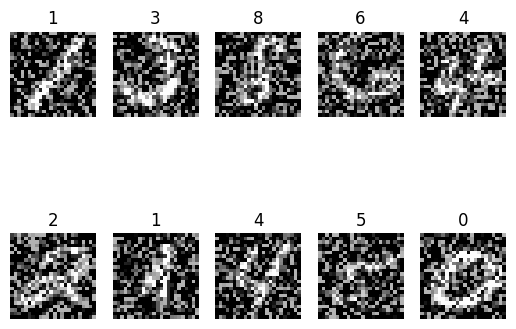

In [72]:
# -- display first ten small train examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xsmall[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Ysmall[i].argmax(-1)))
    plt.axis('off')

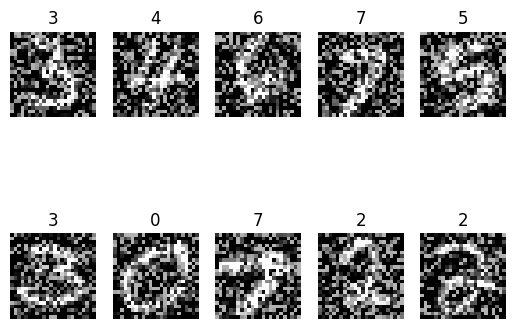

In [73]:
# -- display first ten val examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xval[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Yval[i].argmax(-1)))
    plt.axis('off')

In [75]:
# -- training options; these are suggestions, feel free to experiment
trainopt = {
    'eta': 1,   # initial learning rate
    'maxiter': 100_000,   # max number of iterations (updates) of SGD
    'display_iter': 20_000,  # display batch loss every display_iter updates
    'batch_size': 10,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .2  # drop eta every eta_frac fraction of the max iterations
                    # so if eta_frac is .2, and maxiter is 10000, drop eta every 2000 iterations
}

NFEATURES = Xsmall.shape[1]

seed = np.random.RandomState(2341)  # to make sure everyone starts from the same point
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES)) # -- with random seed fixed

model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

# set the (initial?) set of lambda values to explore
lambdas = np.array([0.5, 0.05, 0.005])

# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
small_trained_models = dict()
large_trained_models = dict()

# -- small train set: sweep the lambda values
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    trained_model, valErr, trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
    small_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('small train set model: -> lambda = %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
# -- model trained on large train set
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    trained_model, valErr, trainErr = runTrainVal(Xlarge, Ylarge, copy.deepcopy(model), Xval, Yval, trainopt)
    large_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('large train set model: -> lambda = %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
best_small_trained_lambda = 0.
best_small_trained_model = None
best_small_trained_val_err = 100.
for lambda_,results in small_trained_models.items():
    if results['val_err'] < best_small_trained_val_err:
        best_small_trained_val_err = results['val_err']
        best_small_trained_model = results['model']
        best_small_trained_lambda = lambda_
        
best_large_trained_lambda = 0.
best_large_trained_model = None
best_large_trained_val_err = 100.
for lambda_,results in large_trained_models.items():
    if results['val_err'] < best_large_trained_val_err:
        best_large_trained_val_err = results['val_err']
        best_large_trained_model = results['model']
        best_large_trained_lambda = lambda_

print("Best small train model val err:", best_small_trained_val_err)
print("Best small train model lambda:", best_small_trained_lambda)
print("Best large train model val err:", best_large_trained_val_err)
print("Best large train model lambda:", best_large_trained_lambda)

       0 batch loss: 2.274
   20000 batch loss: 0.001
   40000 batch loss: 0.000
   60000 batch loss: 0.000
   80000 batch loss: 0.000
small train set model: -> lambda = 0.5000, train error: 0.00, val error: 32.00
       0 batch loss: 2.295
   20000 batch loss: 0.000
   40000 batch loss: 0.000
   60000 batch loss: 0.000
   80000 batch loss: 0.000
small train set model: -> lambda = 0.0500, train error: 0.00, val error: 31.65
       0 batch loss: 2.325
   20000 batch loss: 0.000
   40000 batch loss: 0.000
   60000 batch loss: 0.000
   80000 batch loss: 0.000
small train set model: -> lambda = 0.0050, train error: 0.00, val error: 31.50
       0 batch loss: 2.254
   20000 batch loss: 0.092
   40000 batch loss: 0.015
   60000 batch loss: 0.019
   80000 batch loss: 0.055
large train set model: -> lambda = 0.5000, train error: 0.00, val error: 28.70
       0 batch loss: 2.273
   20000 batch loss: 0.021
   40000 batch loss: 0.029
   60000 batch loss: 0.024
   80000 batch loss: 0.019
large tra

In [76]:
#Generate a Kaggle submission file using `model`

#for model trained on small_train
kaggleX = load_data(data_fn, 'kaggle')
kaggleYhat_small = predict(kaggleX, best_small_trained_model).argmax(-1)
save_submission('submission-small.csv', kaggleYhat_small)

#for model trained on large_train
kaggleYhat_large = predict(kaggleX, best_large_trained_model).argmax(-1)
save_submission('submission-large.csv', kaggleYhat_large)


Saved: submission-small.csv
Saved: submission-large.csv
